# GPT-3 embeddings for code on IJ Community

* [Query: vector similarity]()
* [Query: aproximate NN index]()
* [Retrieval]()
* [OpenAI Embeddings]()
* [Bonus: data exploraitons]()


In [ ]:
!wget https://raw.githubusercontent.com/bzz/jet-search/master/requirements.txt
%pip install -r requirements.txt

In [4]:
model="text-embedding-ada-002"
code_emb_file = "ij-communit-platform-functions-embeddings.pkl"
code_emb_index_file = 'ij-communit-platform-functions-embeddings.ann'

ON_CLOUD = 'google.colab' in str(get_ipython())

if ON_CLOUD:
  from google.colab import auth
  auth.authenticate_user()

In [ ]:
# on collab
# !gsutil cp "gs://cc-eval/cs/$code_emb_file" .
# !gsutil cp "gs://cc-eval/cs/$code_emb_index_file" .

# on Datalore
!wget 'https://storage.googleapis.com/semantic-cs/ij-communit-platform-functions-embeddings.ann'
!wget 'https://storage.googleapis.com/semantic-cs/ij-communit-platform-functions-embeddings.pkl'

## Query

### Query: vector similarity (precise)



In [2]:
from openai.embeddings_utils import cosine_similarity
from openai.embeddings_utils import get_embedding

def search_functions(df, code_query, n=3, pprint=True, n_lines=7):
    embedding = get_embedding(code_query, engine='text-embedding-ada-002')
    df['similarities'] = df.code_embedding.apply(lambda x: cosine_similarity(x, embedding))

    res = df.sort_values('similarities', ascending=False).head(n)
    if pprint:
        for r in res.iterrows():
            print(r[1].filepath+":"+r[1].function_name + "  score=" + str(round(r[1].similarities, 3)))
            print("\n".join(r[1].code.split("\n")[:n_lines]))
            print('-'*70)
    return res

In [5]:
import pandas as pd

df_csv = pd.read_pickle(code_emb_file, compression='gzip')

In [8]:
import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

res = search_functions(df_csv, 'Places where API for syntax highliting is used', n=5)

usageView/src/com/intellij/usages/Usage.java:highlightInEditor  score=0.821
void highlightInEditor();
----------------------------------------------------------------------
testFramework/src/com/intellij/testFramework/fixtures/CodeInsightTestFixture.java:checkHighlighting  score=0.81
long checkHighlighting();
----------------------------------------------------------------------
platform-api/src/com/intellij/openapi/options/colors/ColorSettingsPage.java:getHighlighter  score=0.808
@NotNull SyntaxHighlighter getHighlighter();
----------------------------------------------------------------------
analysis-api/src/com/intellij/lang/documentation/ClientDocumentationSettings.java:isHighlightingOfCodeBlocksEnabled  score=0.802
boolean isHighlightingOfCodeBlocksEnabled();
----------------------------------------------------------------------
editor-ui-ex/src/com/intellij/openapi/editor/ex/util/LayeredHighlighterIterator.java:getActiveSyntaxHighlighter  score=0.8
@NotNull
  SyntaxHighlighter g

In [ ]:
res = search_functions(df_csv, 'definition of API for syntax highliting', n=5)

### Query: nearest neighbors index (approximate)

Instead of comparing query embedding to every vector to find the closest N, let's use an approximate index (built below in [OpenAI Embeddings]() section)

In [ ]:
from annoy import AnnoyIndex

emb_dimensions = 1536 # OpenAI embeddings 
emb_index_file = 'ij-communit-platform-functions-embeddings.ann'
index = AnnoyIndex(emb_dimensions, 'dot')
index.load(emb_index_file)

In [16]:
print(f"Total number of verctors: {len(df_csv)}")

Total number of verctors: 175241


In [39]:
from openai.embeddings_utils import get_embedding

def search_functions_in_index(df, index, code_query, n=3, pprint=True, n_lines=7):
    embedding = get_embedding(code_query, engine='text-embedding-ada-002')
    # search_k is important! it affects runtime performance and accuracy
    # see https://github.com/spotify/annoy#tradeoffs
    res = index.get_nns_by_vector(embedding, n, include_distances=True, search_k=10000)
    
    if pprint:
        for (i, similarity) in zip(res[0], res[1]):
            result = df.iloc[i]
            print(f"{result.filepath}:{result.function_name} score={str(round(similarity, 3))}")
            print("\n".join(result.code.split("\n")[:n_lines]))
            print()
            print('-'*70)
    df_out = df.iloc[res[0]].reset_index()
    df_out['similarities'] = df_out.apply(lambda x: res[1][x.name] , axis=1)
    return df_out

In [40]:
res = search_functions_in_index(df_csv, index, 'syntax highliting API declaration', n=5)

usageView/src/com/intellij/usages/Usage.java:highlightInEditor score=0.813
void highlightInEditor();

----------------------------------------------------------------------
analysis-api/src/com/intellij/lang/documentation/ClientDocumentationSettings.java:isHighlightingOfCodeBlocksEnabled score=0.807
boolean isHighlightingOfCodeBlocksEnabled();

----------------------------------------------------------------------
testFramework/src/com/intellij/testFramework/fixtures/CodeInsightTestFixture.java:checkHighlighting score=0.807
long checkHighlighting();

----------------------------------------------------------------------
ide-core/src/com/intellij/ide/dnd/DnDEvent.java:hideHighlighter score=0.801
void hideHighlighter();

----------------------------------------------------------------------
analysis-api/src/com/intellij/lang/documentation/ClientDocumentationSettings.java:isHighlightingOfQuickDocSignaturesEnabled score=0.794
boolean isHighlightingOfQuickDocSignaturesEnabled();

----------

In [41]:
res

,index,code,function_name,filepath,n_tokens,tokens,code_embedding,similarities
0,1204,void highlightInEditor();,highlightInEditor,usageView/src/com/intellij/usages/Usage.java,5,"[1019, 11415, 644, 9597, 2178]","[-0.01926850900053978, -0.001198320067487657, ...",0.813251
1,158545,boolean isHighlightingOfCodeBlocksEnabled();,isHighlightingOfCodeBlocksEnabled,analysis-api/src/com/intellij/lang/documentati...,9,"[6245, 374, 30930, 287, 2173, 2123, 30904, 557...","[-0.022517485544085503, 0.014456006698310375, ...",0.806812
2,77438,long checkHighlighting();,checkHighlighting,testFramework/src/com/intellij/testFramework/f...,5,"[4930, 1817, 30930, 287, 2178]","[-0.034275881946086884, 0.006931202951818705, ...",0.806672
3,167831,void hideHighlighter();,hideHighlighter,ide-core/src/com/intellij/ide/dnd/DnDEvent.java,5,"[1019, 10477, 30930, 261, 2178]","[-0.0321929045021534, 5.1633367547765374e-05, ...",0.801489
4,158544,boolean isHighlightingOfQuickDocSignaturesEnab...,isHighlightingOfQuickDocSignaturesEnabled,analysis-api/src/com/intellij/lang/documentati...,11,"[6245, 374, 30930, 287, 2173, 25310, 9743, 741...","[-0.03709271177649498, 0.015990113839507103, 0...",0.793928


## Retrieval

### Java & Kotlin Parsers

In [ ]:
%pip install -r requirement.txt
## tree-sitter, openAI

# mkidr -p parsers
!git clone 'https://github.com/tree-sitter/tree-sitter-java' parsers/tree-sitter-java
!git clone 'https://github.com/fwcd/tree-sitter-kotlin' parsers/tree-sitter-kotlin

In [ ]:
from tree_sitter import Language, Parser

Language.build_library( # Build and store native libraries for parsers
  'build/my-languages.so',
  [
    'parsers/tree-sitter-java',
    'parsers/tree-sitter-kotlin'
  ]
)

False

In [ ]:
# both queries include decaration \w empty body (e.g from interfaces)

JA_LANGUAGE = Language('build/my-languages.so', 'java')
jParser = Parser()
jParser.set_language(JA_LANGUAGE)
jQuery = JA_LANGUAGE.query("""
(method_declaration
  name: (identifier) @method.name) @method.decl
""")

KT_LANGUAGE = Language('build/my-languages.so', 'kotlin')
kParser = Parser()
kParser.set_language(KT_LANGUAGE)
kQuery = KT_LANGUAGE.query("""
(function_declaration
  (simple_identifier)+ @func.name) @func.decl
""")

In [ ]:
jTree = jParser.parse(bytes("""
public class Test {
	/**
	 * JavaDoc
	 */
	boolean isValid();
	public static void main(String[] args){
		System.out.println("Hello, World!");
	}
	fianl String test;
	static @NotNull ModalTaskOwner project(@NotNull Project project) {
		return ApplicationManager.getApplication().getService(TaskSupport.class).modalTaskOwner(project);
	}
}
""", "utf8"))

jcaptures = jQuery.captures(jTree.root_node)
assert len(jcaptures) == 6
[(c[0].type, c[0].text) for c in jcaptures]

[('method_declaration', b'boolean isValid();'),
 ('identifier', b'isValid'),
 ('method_declaration',
  b'public static void main(String[] args){\n\t\tSystem.out.println("Hello, World!");\n\t}'),
 ('identifier', b'main'),
 ('method_declaration',
  b'static @NotNull ModalTaskOwner project(@NotNull Project project) {\n\t\treturn ApplicationManager.getApplication().getService(TaskSupport.class).modalTaskOwner(project);\n\t}'),
 ('identifier', b'project')]

In [ ]:
kTree = kParser.parse(bytes("""
package org.kotlinlang.play         // 1

fun main() {                        // 2
    println("Hello, World!")        // 3
}                                   // 4

/* comment */
fun onChanged()

fun multiply(x: Int, y: Int = N) = x * y// 5

override fun getMessageBus(): MessageBus {
    error("Not supported")
}

class Customer                      // 6
""", "utf8"))

kcaptures = kQuery.captures(kTree.root_node)
# assert len(kcaptures) == 6
[(c[0].type, c[0].text) for c in kcaptures]

[('function_declaration',
  b'fun main() {                        // 2\n    println("Hello, World!")        // 3\n}'),
 ('simple_identifier', b'main'),
 ('simple_identifier', b'main'),
 ('function_declaration', b'fun onChanged()'),
 ('simple_identifier', b'onChanged'),
 ('simple_identifier', b'onChanged'),
 ('function_declaration', b'fun multiply(x: Int, y: Int = N) = x * y'),
 ('simple_identifier', b'multiply'),
 ('simple_identifier', b'multiply'),
 ('function_declaration',
  b'override fun getMessageBus(): MessageBus {\n    error("Not supported")\n}'),
 ('simple_identifier', b'getMessageBus'),
 ('simple_identifier', b'getMessageBus')]

### Parse & extract funtions

In [ ]:
import codecs
import os
import re
from pathlib import Path
all_funcs = []
parsers = { ".java": jParser, ".kt": kParser}
queries =  { ".java": jQuery, ".kt": kQuery}

code_root = "../intellij-community/platform"
code_files = "ij-communit-platform-files.csv"
code_functions = "ij-communit-platform-functions.csv"
decl_re = re.compile('.*\.decl')
name_re = re.compile('.*\.name')

def get_functions(rel_path: str):
    file = os.path.join(code_root, rel_path)
    # print(f"reading '{file}'")
    with open(file, 'rb') as f:
        ext = rel_path[rel_path.rindex("."):]
        p = parsers[ext]
        tree = p.parse(f.raw.readall())

        q = queries[ext]
        cs = iter(q.captures(tree.root_node))

        for c in cs:
            fn_code = ""
            try:
                if decl_re.match(c[1]):
                    fn_code = codecs.utf_8_decode(c[0].text)[0]
                    next_c = next(cs)
                    fn_name = codecs.utf_8_decode(next_c[0].text)[0]
                    if ext == ".kt": # Kotlin parser matches the name twice ¯\_(ツ)_/¯
                        assert next_c[0].text == next(cs)[0].text, f"{rel_path}: {fn_code}"
                elif name_re.match(c[1]):
                    fn_name = codecs.utf_8_decode(c[0].text)[0]
                else:
                    assert False, "neither declaration nor name"
                yield {"code": fn_code, "function_name": fn_name, "filepath": rel_path}
            except StopIteration as e:
                print(f"{rel_path}: no name after {fn_code}")

with open(code_files) as f:
    # read, parse and query every file (find all the functions)
    for code_file in f.readlines():
        funcs = list(get_functions(code_file.strip()))
        for func in funcs:
            all_funcs.append(func)


In [ ]:
import pandas as pd

code_functions = "ij-communit-platform-functions.csv.gz"

#df = pd.DataFrame(all_funcs)
#df.to_csv(code_functions, index=False, compression='gzip')
df = pd.read_csv(code_functions, compression='gzip')
df.head()

,code,function_name,filepath
0,@Override\n protected void update(final AnAct...,update,lang-api/src/com/intellij/execution/ui/actions...
1,private boolean isToFocus(final ViewContext co...,isToFocus,lang-api/src/com/intellij/execution/ui/actions...
2,@Override\n protected void actionPerformed(fi...,actionPerformed,lang-api/src/com/intellij/execution/ui/actions...
3,@Override\n public @NotNull ActionUpdateThrea...,getActionUpdateThread,lang-api/src/com/intellij/execution/ui/actions...
4,@Override\n public final void update(final @N...,update,lang-api/src/com/intellij/execution/ui/actions...


## OpenAI Embeddings

In [ ]:
model="text-embedding-ada-002"
code_emb_file = "ij-communit-platform-functions-embeddings.pkl"
code_emb_index_file = 'ij-communit-platform-functions-embeddings.ann'

### Tokenize & encode

In [ ]:
# count the tokens

import tiktoken
tokenizer = encoding = tiktoken.encoding_for_model(model) #tiktoken.get_encoding("cl100k_base")

df['n_tokens'] = df['code'].apply(lambda x: len(tokenizer.encode(x)))


In [ ]:
df.sample(5)

,code,function_name,filepath,n_tokens
117876,public abstract boolean isInsideScreenBounds(i...,isInsideScreenBounds,ide-core/src/com/intellij/openapi/wm/WindowMan...,16
66324,@Override\n public void fileMoved(@NotNull Vi...,fileMoved,core-api/src/com/intellij/openapi/vfs/VirtualF...,25
2448,protected abstract void update(@NotNull VcsCon...,update,vcs-impl/src/com/intellij/openapi/vcs/actions/...,18
107659,public static @Nullable ListSelection<? extend...,createDiffProducers,vcs-impl/src/com/intellij/openapi/vcs/changes/...,183
17736,@Override\n protected boolean isSelected(@Not...,isSelected,external-system-impl/src/com/intellij/openapi/...,25


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175242 entries, 0 to 175241
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   code           175242 non-null  object
 1   function_name  175242 non-null  object
 2   filepath       175242 non-null  object
 3   n_tokens       175242 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.3+ MB


In [ ]:
df.describe()

,n_tokens
count,175242.000000
mean,68.927255
std,126.858943
min,3.000000
25%,20.000000
50%,34.000000
75%,73.000000
max,13406.000000


In [ ]:
df[df['n_tokens'] == 5]

,code,function_name,filepath,n_tokens
70,void onStepChanged();,onStepChanged,platform-impl/src/com/intellij/ui/wizard/Wizar...,5
327,void selectionInverted();,selectionInverted,platform-impl/src/com/intellij/ide/util/Elemen...,5
374,protected abstract int getColumn();,getColumn,platform-impl/src/com/intellij/ide/util/GotoLi...,5
470,fun closeTipDialog(),closeTipDialog,platform-impl/src/com/intellij/ide/util/TipAnd...,5
475,JComponent getComponent();,getComponent,platform-impl/src/com/intellij/ide/util/TipUIU...,5
...,...,...,...,...
171692,protected abstract void perform();,perform,platform-api/src/com/intellij/ide/util/treeVie...,5
171932,boolean canGoFurther();,canGoFurther,platform-impl/src/com/intellij/openapi/ui/play...,5
173466,override fun toString(): String,toString,lang-api/src/com/intellij/codeInsight/hints/pr...,5
173469,fun mouseExited() {},mouseExited,lang-api/src/com/intellij/codeInsight/hints/pr...,5


In [ ]:
df[df['n_tokens'] > 1300] #8192

,code,function_name,filepath,n_tokens
9651,fun JsonIndexDiagnostic.generateHtml(target: A...,generateHtml,lang-impl/src/com/intellij/util/indexing/diagn...,3057
10772,protected fun traverseInstanceGraph(progress: ...,traverseInstanceGraph,platform-impl/src/com/intellij/diagnostic/hpro...,2885
10774,private fun computeDominatorFlameGraph(nav: Ob...,computeDominatorFlameGraph,platform-impl/src/com/intellij/diagnostic/hpro...,4670
12055,"fun createResolverImpl(project: Project?, indi...",createResolverImpl,lang-impl/src/com/intellij/openapi/projectRoot...,1842
16234,@Override\n public void actionPerformed(@NotN...,actionPerformed,platform-impl/src/com/intellij/ide/actions/Act...,1561
...,...,...,...,...
168282,private void initComponents() {\n AnAction ...,initComponents,lang-impl/src/com/intellij/find/impl/FindPopup...,4873
168309,private void findSettingsChanged() {\n if (...,findSettingsChanged,lang-impl/src/com/intellij/find/impl/FindPopup...,1493
169564,override fun saveEntities(storage: EntityStora...,saveEntities,workspaceModel/jps/src/com/intellij/workspaceM...,2539
172968,protected void initUI(final ChooseByNamePopupC...,initUI,lang-impl/src/com/intellij/ide/util/gotoByName...,2436


In [ ]:
df['n_tokens'].sum()

12078950

In [ ]:
print(f"Price: ${(df['n_tokens'].sum() / 1000) * 0.0004:.2f}")
print(f"Min time: {((df['n_tokens'].sum() / 2048) / 3500):.2f} min")
# ~5.900 request total, 2k each

# limit
#  3,500 RPM / 350,000 TPM

Price: $4.83
Min time: 1.69 min


In [ ]:
import numpy as np

# replace newlines, which can negatively affect performance. See https://github.com/openai/openai-python/blob/aa133ce3a883e2957aa1e0111ee27dfef986e787/openai/embeddings_utils.py#L20
df['tokens'] = df['code'].apply(lambda text: tokenizer.encode(text.replace("\n", " ")))

### Fetch the embeddings

In [ ]:
import numpy as np
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

# We'll batch 2048 chunks into a single API call
# each chunk up to 8192 tokens
df_n = df[df['n_tokens'] < 8192]


In [ ]:
df_n.head()

,code,function_name,filepath,n_tokens
0,@Override\n protected void update(final AnAct...,update,lang-api/src/com/intellij/execution/ui/actions...,67
1,private boolean isToFocus(final ViewContext co...,isToFocus,lang-api/src/com/intellij/execution/ui/actions...,39
2,@Override\n protected void actionPerformed(fi...,actionPerformed,lang-api/src/com/intellij/execution/ui/actions...,63
3,@Override\n public @NotNull ActionUpdateThrea...,getActionUpdateThread,lang-api/src/com/intellij/execution/ui/actions...,25
4,@Override\n public final void update(final @N...,update,lang-api/src/com/intellij/execution/ui/actions...,76


In [ ]:
from typing import List
from tenacity import retry, stop_after_attempt, wait_random_exponential
import numpy as np

@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embeddings(
    list_of_tokens: List[int], engine="text-embedding-ada-002"
) -> List[np.ndarray]: #List[float]
    assert len(list_of_tokens) <= 2048, "The batch size should not be larger than 2048."

    # replace newlines, which accoring to OpenAI can negatively affect performance.
    # list_of_tokens = [text.replace("\n", " ") for text in list_of_tokens]
    ## we did this earlier, during tokenization

    data = openai.Embedding.create(input=list_of_tokens, engine=engine).data
    data = sorted(data, key=lambda x: x["index"])  # maintain the same order as input.
    return [np.array(d["embedding"]) for d in data]


In [ ]:
# All the API query happens here! 86 API requests on /platform
df_n['code_embedding'] = df_n.groupby(np.arange(len(df_n))//2048)['code'].transform(lambda x: get_embeddings(x.tolist(), engine=model))

In [ ]:
df_n.to_pickle(code_emb_file, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [ ]:
df_n.head()

### Build the Index

To speed up the query for nearest vectors, instead of doing a full scan over the corpus an index can be built in advance - a datastructure for approximate nearest neighbors search. 

We are going to use https://github.com/spotify/annoy. 

https://github.com/facebookresearch/faiss is also a good but official builds are _only_ on Anaconda. (Be carefull running someone else's builds from Pypi!)

In [ ]:
# build the index
from annoy import AnnoyIndex

emb_dimensions = df_csv.iloc[0].code_embedding.shape[0]

# Metric can be "angular", "euclidean", "manhattan", "hamming", or "dot" 
# This will affect the results significantly! 
# Use 'dot' for cosin similarty, to compare with Precise section.
index = AnnoyIndex(emb_dimensions, 'dot')


df_csv.apply(lambda x: index.add_item(x.name, x.code_embedding), axis=1)

index.build(200)
index.save(f"{code_emb_index_file}")

True

## Bonus: data exploration

In [ ]:
df[df['function_name'] == 'getNavigationOffset']

,code,function_name,filepath
1205,default int getNavigationOffset() {\n FileE...,getNavigationOffset,usageView/src/com/intellij/usages/Usage.java
1239,@Override\n public int getNavigationOffset() ...,getNavigationOffset,usageView/src/com/intellij/usages/UsageInfo2Us...
1277,int getNavigationOffset();,getNavigationOffset,usageView/src/com/intellij/usages/UsageInfoAda...
78941,public int getNavigationOffset() {\n if (my...,getNavigationOffset,core-api/src/com/intellij/usageView/UsageInfo....


In [ ]:
print(df.function_name.describe())
print()
print(df.function_name.value_counts().head(50))

count              175242
unique              62280
top       actionPerformed
freq                 1986
Name: function_name, dtype: object

function_name
actionPerformed                 1986
toString                        1700
update                          1659
getActionUpdateThread           1413
dispose                         1029
equals                           995
hashCode                         919
getInstance                      900
getName                          620
run                              605
create                           552
getIcon                          528
get                              505
getText                          419
isEnabled                        404
remove                           403
apply                            401
getProject                       395
isSelected                       373
reset                            370
clear                            359
getState                         358
setSelected                     

<Axes: >

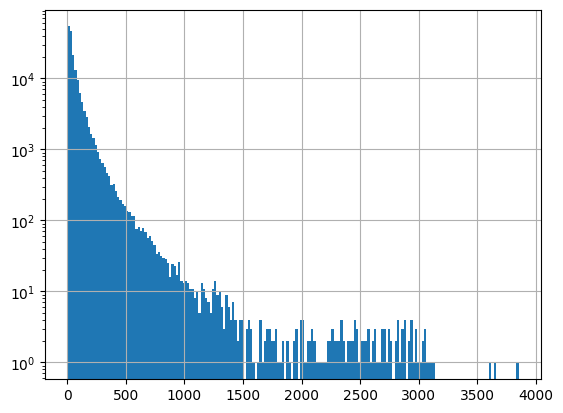

In [ ]:
df[df['n_tokens'] < 4000]['n_tokens'].hist(bins=200, log=True)